# Step 0: Environment setup

<span style="color:blue">Have to be caustious with the versions of your libraries, especially PIL, Pillow and Python, on my Windows 10, other combinations are tried such as Pillow 5.2.0 and Python 3.6.6, I can never get correct Image.pyd file imported...ಥ_ಥ...The error below will be encountered:</span>

```
---------------------------------------------------------------------------
ImportError                               Traceback (most recent call last)
<ipython-input-4-7246464f6f43> in <module>()
      1 import os
----> 2 from PIL import Image
      3 
      4 current_path = os.getcwd()
      5 for root, dirs, files in os.walk(current_path, topdown=False):

~\Anaconda\lib\site-packages\PIL\Image.py in <module>()
     65     cwd = os.getcwd()
     66     print(cwd)
---> 67     from . import _imaging as core
     68     if __version__ != getattr(core, 'PILLOW_VERSION', None):
     69         raise ImportError("The _imaging extension was built for another "

ImportError: DLL load failed: The specified module could not be found.
```
<span style="color:blue">Use conda-forge if you are prompted by anaconda that certain package can't be accessed in this channel</span>

In [1]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=6, releaselevel='final', serial=0)

In [2]:
import PIL
PIL.PILLOW_VERSION

'4.2.0'

In [3]:
PIL.VERSION

'1.1.7'

import the most library for particle trajectory tracking `trackpy` itself and its sister project, `pims`.

In [4]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

In [6]:
mpl.__version__

'2.1.0'

# Step 0: Prepare images format and read the Data

Convert tif images into jpg images

Skip if not needed

In [7]:
import os
from PIL import Image

current_path = os.getcwd()

output_path = current_path+"/jpg_output"
if not os.path.exists(output_path):
    os.makedirs(output_path)
else:
    print("Output folder already existed, please delete it and rerun")
    
for root, dirs, files in os.walk(current_path+"/tiff", topdown=False):
    for name in files:
        #print(os.path.join(root, name))
        #if os.path.splitext(os.path.join(root, name))[1].lower() == ".tiff":
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
            if os.path.isfile(os.path.splitext(os.path.join(output_path, name))[0] + ".jpg"):
                print("A jpeg file already exists for %s" % name)
            # If a jpeg with the name does *NOT* exist, covert one from the tif.
            else:
                outputfile = os.path.splitext(os.path.join(output_path, name))[0] + ".jpg"
                try:
                    im = Image.open(os.path.join(root, name))
                    print("Converting jpeg for %s" % name)
                    im.thumbnail(im.size)
                    im.save(outputfile, "JPEG", quality=100)
                except e:
                    print(e)

Output folder already existed, please delete it and rerun
A jpeg file already exists for RECEPTOR snr 7 density mid t000 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t001 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t002 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t003 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t004 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t005 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t006 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t007 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t008 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t009 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t010 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t011 z0.tif
A jpeg file already exists for RECEPTOR snr 7 density mid t012 z0.tif
A jpeg file already exists for R

Opening images or video
To get our data into Python, we use our sister project, PIMS (Python Image Sequence). PIMS makes is easy and convenient to load and process video data from many formats with one consistent interface.

You can read in:

* a directory or zipfile of sequential images using `ImageSequence`

* a multi-frame TIFF file using `TiffStack`

* a video (AVI, MOV, etc.) using Video

* specialty formats used in microscopy and scientific video capture:
    * Cine
    * LSM
    * Files supported by Bioformats
    * ND2 using PIMS_ND2
    
ImageSequence works out of the box, so it's recommended to start with. 

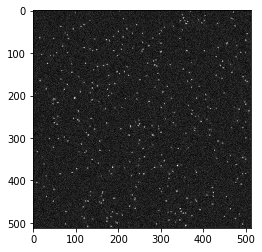

In [8]:
frames = pims.ImageSequence('./jpg_output/*.jpg', as_grey=True)
#frames[0]
plt.imshow(frames[0])
#frames[0].frame_no
#frames[0].metadata 

# Step 2: Locate Features  
The algorithm looks for bright features; since my features are bright, I set invert=False.

locate returns a spreadsheet-like object called a DataFrame. It lists

* each feature's position,
* various characterizations of its appearance, which we will use to filter out spurious features,
* the "signal" strength and an estimate of uncertainty, both derived from this paper


In [9]:
f = tp.locate(frames[0], 11, invert=False)
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,4.725926,75.370370,57.142763,2.409856,0.139453,3.809518,982.0,-0.475327,0
1,5.976309,99.248753,339.470340,1.760434,0.089826,28.783021,1560.0,0.191119,0
3,6.557143,47.171429,74.073952,3.279808,0.422384,2.962958,1082.0,-1.198207,0
5,7.450980,284.568627,75.555431,3.056425,0.266029,3.386238,1065.0,-0.952064,0
6,6.965054,336.295699,78.730029,3.280359,0.115196,3.174598,1126.0,-3.621640,0


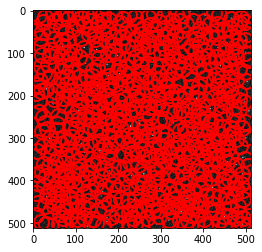

In [10]:
plt.figure()  # make a new figure
tp.annotate(f, frames[0]);

**Plot mass distribution**

Based on this mass distribution and the later result from `tp.locate`, I purposely screen out the first peak by setting the minimum value of mass as 200. Only the second peak is considered as the targets. It's clear that all targets are kept after removing the first peak. 

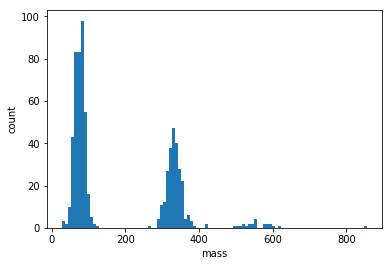

In [11]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=100)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

## Fine-tune feature parameters

Based on the information from the parameter distribution to better locate particles.

Diameter parameter has to be an odd value.

`tp.annotate` may mess up with `plt.subplot` sometime.

It's very helpful to zoom in the image to give a much clearer vision, since it's not very clear in the documentation about how to change the size of circles. 

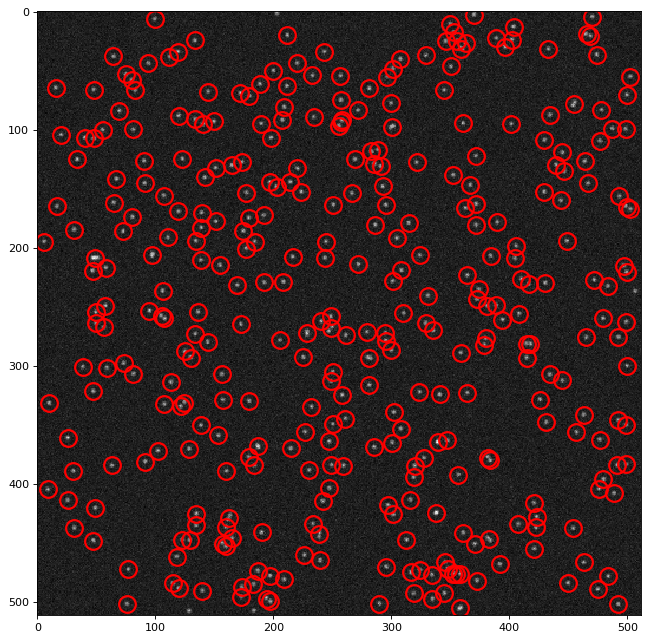

In [19]:
f = tp.locate(frames[0], diameter=7, separation=2, minmass=200, noise_size=1, smoothing_size=11)
plt.figure(num=None, figsize=(20, 10), dpi=80)
#plt.imshow(frames[0])
tp.annotate(f, frames[0]);

#plt.figure()
#plt.subplot(121)
#tp.annotate(f, frames[0])
#plt.subplot(122)
#plt.imshow(frames[0])dd
#plt.show()

## Check for subpixel accuracy

A quick way to check for subpixel accuracy is to check that the decimal part of the x and/or y positions are evenly distributed. 

`tp.subpx_bias` is a convenience plotting function for this. If subpixel accuracy is good, this should be flat. If it depressed in the middle, try using a larger value for feature diameter.

Although diameter = 9 gives better result in `tp.subpx_bias`, but parameter = 7 can recognize more particles that are very close to each other. 

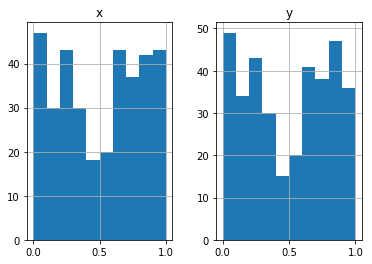

In [20]:
plt.figure()
tp.subpx_bias(f);

## Locate features in all frames

We'll locate features in the first 300 frames from this video. We use 
`tp.batch` which calls `tp.locate` on each frame and collects the results.

In [21]:
f = tp.batch(frames[:100], 11, minmass=200)

Frame 99: 203 features


# Step 3: Link features into particle trajectories
    
We have the locations of the particles in each frame. Next we'll track particles from frame to frame, giving each one a number for identification.

First, we must must specify a maximum displacement, the farthest a particle can travel between frames. We should choose the smallest reasonable value because a large value slows computation time considerably. In this case, 5 pixels is reasonable.

Second, we allow for the possibility that a particle might be missed for a few frames and then seen again. (Perhaps its "mass" slipped below our cutoff due to noise in the video.) Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance. We'll choose 3.

In [22]:
t = tp.link_df(f, 10, memory=5)
t.head()

Frame 99: 203 trajectories present.


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,5.976309,99.248753,339.470340,1.760434,0.089826,28.783021,1560.0,0.191119,0,0
171,307.330680,434.208818,345.607896,1.744030,0.096342,28.783021,1649.0,0.157184,0,1
172,313.762162,113.192793,352.380372,1.802734,0.051195,28.783021,1656.0,0.155019,0,2
173,316.328199,281.215640,357.248089,1.758864,0.076885,30.476140,1710.0,0.140131,0,3
174,321.655868,47.243888,346.242816,1.721076,0.062324,30.476140,1618.0,0.167546,0,4


## Filter spurious trajectories.
We have more filtering to do. Empheremeral trajectories -- seen only for a few frames -- are usually spurious and never useful. The convenience function `filter_stubs` keeps only trajectories that last for a given number of frames.

In [23]:
t1 = tp.filter_stubs(t, 10)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 2199
After: 1026


We can also filter trajectories by their appearance. At this stage, with trajectories linked, we can look at a feature's "average appearance" throughout its trajectory, giving a more accurate picture.

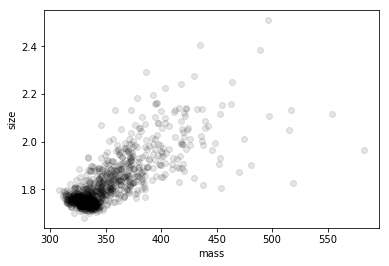

In [24]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

The particles with especially **low mass** or especially **large size** are probably out of focus or aggregated, respectively. It is best to experiment by trial and error, filtering out regions of mass-size space and looking at the results using `tp.annotate` and `tp.circle`. In the end, we need to separate the good particles from the spurious ones, and it doesn't matter how we get it done.

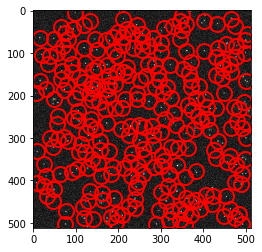

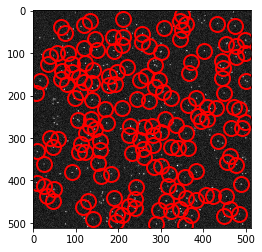

In [25]:
#t2 = t1[((t1['mass'] > 310) & (t1['size'] < 2.2) & (t1['ecc'] < 0.1))] #this step is actually not needed for this dataset
#plt.figure()
#tp.annotate(t2[t2['frame'] == 0], frames[0]);
tp.annotate(t[t['frame'] == 0], frames[0]);
tp.annotate(t1[t1['frame'] == 0], frames[0]);

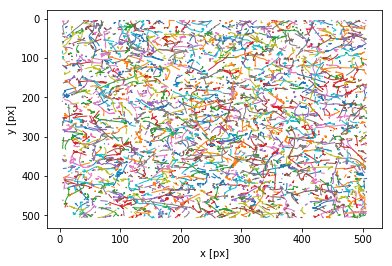

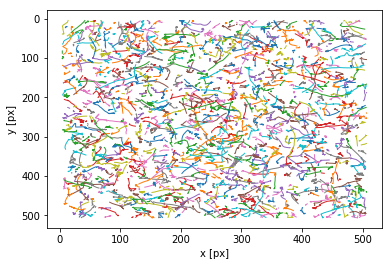

In [26]:
plt.figure()
tp.plot_traj(t);
tp.plot_traj(t1);

## Remove overall drift

Compute the overall drifting motion, which we will subtract away, adopting the reference frame of the particles' average position.

C:\Users\Yue Ma\Anaconda\lib\site-packages\trackpy\utils.py:313: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  return df.sort_values(*args, by=by, **kwargs)
C:\Users\Yue Ma\Anaconda\lib\site-packages\trackpy\motion.py:289: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  dx = f_diff.loc[mask, pos_columns + ['frame']].groupby('frame').mean()


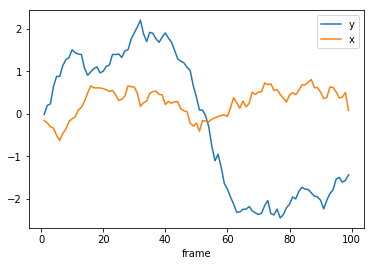

In [32]:
#print(t1)
d = tp.compute_drift(t1)
plt.figure()
d.plot();

In [33]:
tm = tp.subtract_drift(t1.copy(), d)

With the overall drifting motion subtracted out, we plot the trajectories again. We observe nice patterns.

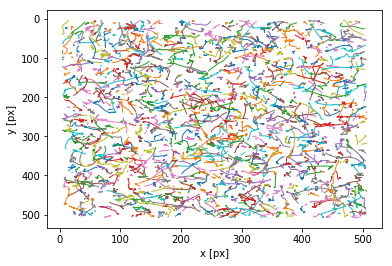

In [34]:
plt.figure()
ax = tp.plot_traj(tm)

# Step 4: Analyze trajectories
## Mean Squared Displacement of Individal Probes
Compute the mean squared displacement of each particle and plot MSD vs. lag time.

`trackpy.motion.imsd(traj, mpp, fps, max_lagtime=30, statistic=u’msd’)`

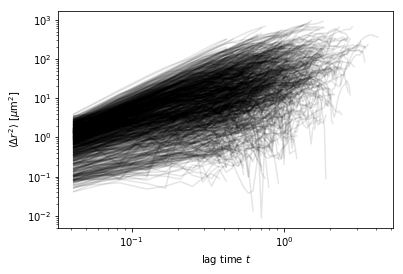

In [35]:
im = tp.imsd(tm, 100/285., 24)  # microns per pixel = 100/285., frames per second =30
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

## Ensemble Mean Squared Displacement

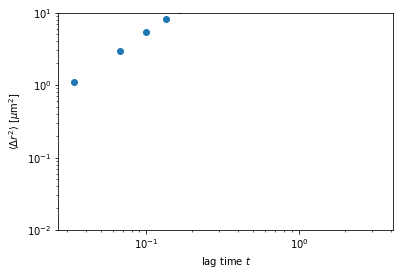

In [36]:
em = tp.emsd(tm, 100/285., 30)
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10));

We can easily fit this ensemble mean-squared displacement to a power law,  Atn , using a convenience function, `fit_powerlaw`, that performs a linear regression in log space.

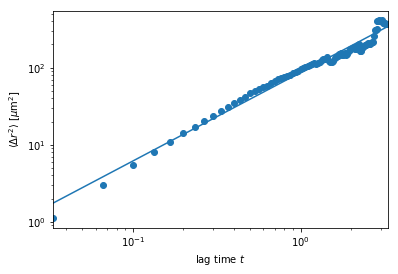

,n,A
msd,1.148647,86.570364


In [37]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots

In water, a viscous material, the expected power-law exponent  $n$=1 . The value of  $A$=4$D$ , where $D$ is the particles' diffusivity. $D$ is related to viscosity $η$ , particle radius $a$ , and temperature $T$ as 
## $\frac{kT}{6\pi\eta a}$

For particles with a 1  $μm$  diameter in room-temperature water,  $A$≈1.66 . Our value above is far off ....ಥ_ಥ